<a href="https://colab.research.google.com/github/hjornskar-ctrl/dim-clem/blob/main/CNN_with_tes_data_vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift
import tensorflow as tf

# keras imports for the dataset and building our neural network

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

import pandas as pd
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
param_csg = np.load('/content/drive/MyDrive/csg_param_data.npy')


df = pd.DataFrame(param_csg)
df.head()



,0,1,2,3,4
0,0.282638,382.295111,56.0,0.029297,116.0
1,0.255795,380.055693,57.0,0.029297,83.0
2,0.834733,187.148172,34.0,0.048828,125.0
3,0.770519,420.454182,50.0,0.032227,159.0
4,0.909618,424.354512,52.0,0.030273,62.0


I made the parameters into a dataframe, so now I can hopefully scale the data successfully in a much simpler way. I am using z-score since it is much better for regression tasks.

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

parameter_normalized_zscore = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

parameter_normalized_zscore.head()

,0,1,2,3,4
0,-0.893931,0.860082,-0.225213,-0.434271,0.509650
1,-1.004931,0.842774,-0.207989,-0.434271,-0.131175
2,1.389032,-0.648197,-0.604147,-0.046258,0.684421
3,1.123504,1.155011,-0.328559,-0.376069,1.344665
4,1.698691,1.185157,-0.294110,-0.414870,-0.538973


In [6]:
strain_csg = np.load('/content/drive/MyDrive/csg_strain_data.npy')

First I am going to make sure there are no missing parameter values.

In [7]:
np.isnan(param_csg).any()

False

The above shows that there are no missing parameter values.

In [8]:
import numpy as np
import random

# Convert parameters to NumPy array (if it's a Pandas Series/DataFrame)
parameters = np.array(parameter_normalized_zscore)  # Shape: (5000, 5)
strain = np.swapaxes(strain_csg, 1, 2)  # Shape: (5000, 1024, 3)

# Debug prints
print("Converted strain shape:", strain.shape)  # Expected: (5000, 1024, 3)
print("Converted parameters shape:", parameters.shape)  # Expected: (5000, 5)

# Define augmentation functions
def scale_time_series(strain, scale_factor=1.1):
    return strain * scale_factor

def shift_time_series(x, shift_amt):
    return np.roll(x, shift_amt, axis=0)

def add_noise(strain, noise_factor=0.02):
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=strain.shape)
    return strain + noise

def combined_augmentation(strain):
    """Apply multiple augmentations randomly to the time series."""
    if random.random() < 0.5:
        strain = add_noise(strain, noise_factor=0.02)
    if random.random() < 0.5:
        strain = shift_time_series(strain, shift_amt=np.random.randint(-10, 10))
    if random.random() < 0.5:
        strain = scale_time_series(strain, scale_factor=np.random.uniform(0.9, 1.1))
    return strain

#Generate multiple augmented versions per sample
num_augmentations = 5

augmented_strain = []
augmented_parameters = []

for i in range(len(strain)):
    ts = strain[i]
    label = parameters[i]  # Now a NumPy array

    # Keep the original data & labels
    augmented_strain.append(ts)
    augmented_parameters.append(label)  # Now NumPy, so `.reshape(1, -1)` is NOT needed

    for _ in range(num_augmentations):
        aug_ts = combined_augmentation(ts)
        augmented_strain.append(aug_ts)
        augmented_parameters.append(label)  # Label is directly appended

# Convert to NumPy arrays
augmented_strain = np.array(augmented_strain)
augmented_parameters = np.array(augmented_parameters)  #  Now properly (N, 5)

# Debugging prints
print("Final strain shape:", augmented_strain.shape)  # Expected: (5000 * (1+num_augmentations), 1024, 3)
print("Final parameters shape:", augmented_parameters.shape)  # Expected: (5000 * (1+num_augmentations), 5)

#Ensure data-label consistency
assert augmented_strain.shape[0] == augmented_parameters.shape[0], "Mismatch in augmented data and labels!"


Converted strain shape: (3000, 1024, 3)
Converted parameters shape: (3000, 5)
Final strain shape: (18000, 1024, 3)
Final parameters shape: (18000, 5)


Increased num_augmentations

    Now, each original time series generates 5 additional augmented versions.
    If your dataset had 5000 samples, the final dataset will be (5000 × (5+1)) = 30,000 samples.

Always Apply Augmentations (Instead of 50% Chance)

    Previously, each augmentation had only a 50% chance of being applied.
    Now, every augmentation is always applied for more variety

In [9]:
import numpy as np

# Assuming X.shape = (2400, 1024, 3) and y.shape = (2400, 5)


# Define split sizes
train_size = int(0.7 * len(augmented_strain))  # 70% for training
val_size = int(0.15 * len(augmented_strain))   # 15% for validation
test_size = len(augmented_strain) - train_size - val_size  # Remaining 15% for test

# Sequential split
X_train, y_train = augmented_strain[:train_size], augmented_parameters[:train_size]
X_val, y_val = augmented_strain[train_size:train_size + val_size], augmented_parameters[train_size:train_size + val_size]
X_test, y_test = augmented_strain[train_size + val_size:], augmented_parameters[train_size + val_size:]




# Print shapes to verify
print(f"Train set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")


# data augmentation has increased the training set and parameter size to 6000

Train set: X=(12600, 1024, 3), y=(12600, 5)
Validation set: X=(2700, 1024, 3), y=(2700, 5)
Test set: X=(2700, 1024, 3), y=(2700, 5)


I have split the data into three different sets:

The training set, validation set, and testing set.

The model will learn patterns from the labelled data in the training set, improving the weights and biases in the CNN using a loss function like MSE. The hyperparameters of the model will be tuned using the test set.

Then the model will be tested on the test set (which is unseen data), where the obtained values can be compared to the real ones.

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, Add, GlobalAveragePooling1D, Dense, Input, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

def residual_block(x, filters, kernel_size=3, stride=1):
    """Residual block for 1D ResNet."""
    shortcut = x  # Skip connection

    # First Conv1D layer
    x = Conv1D(filters, kernel_size, strides=stride, padding="same",kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second Conv1D layer
    x = Conv1D(filters, kernel_size, strides=1, padding="same",kernel_regularizer=l2(0.0001))(x)  # Stride=1 to maintain size
    x = BatchNormalization()(x)

    # Skip Connection: Match dimensions if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=stride, padding="same",kernel_regularizer=l2(0.0001))(shortcut)  # 1x1 conv to match dimensions
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])  # Add skip connection
    x = ReLU()(x)  # Final activation

    return x

def build_resnet_1d(input_shape, num_outputs):
    """Builds a ResNet-based 1D CNN model for time-series parameter estimation."""
    inputs = Input(shape=input_shape)  # (1024, 3)

    # Initial Conv Layer
    x = Conv1D(64, kernel_size=5, strides=2, padding="same",kernel_regularizer=l2(0.0001))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding="same")(x)  # Reduce temporal size

    # Residual Blocks
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=64, stride=2)  # Downsample
    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=256, stride=2)   # Downsample

    # Global Average Pooling & Fully Connected Layers
    x = Dropout(0.1)(x)
    x = GlobalAveragePooling1D()(x)  # Reduces (time, filters) to (filters,)
    x = Dropout(0.15)(x)
    outputs = Dense(num_outputs, activation="linear",kernel_regularizer=l2(0.0001),name="predictions")(x)  # Predicts 5 parameters (regression)

    model = Model(inputs, outputs)
    return model

# Model initialization
input_shape = (1024, 3)  # 1024 time steps, 3 features
num_outputs = 5  # Predict 5 continuous parameters
resnet_1d = build_resnet_1d(input_shape, num_outputs)
resnet_1d.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1024, 3)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 512, 64)        │          1,024 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 64)        │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 512, 64)        │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 256, 64)        │              0 │ re_lu[0][0]            │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 256, 32)        │          6,176 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 32)        │            128 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 256, 32)        │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 256, 32)        │          3,104 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 256, 32)        │          2,080 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 32)        │            128 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 32)        │            128 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 32)        │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 256, 32)        │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 128, 64)        │          6,208 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128, 64)        │            256 │ conv1d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 451,109 (1.72 MB)

 Trainable params: 448,101 (1.71 MB)

 Non-trainable params: 3,008 (11.75 KB)

Above is the resnet architecture which has been modified to have an input size of (1024,3), and an output of 5 parameters. Will make a diagram of the architecture later.

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Compile the model
 # reduced learning rate to allow for convergence
resnet_1d.compile(optimizer="Adam", loss="mse", metrics=["mae"])

# Early stopping (stops training if val_loss doesn't improve for 25 epochs)
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)


# Train on (2400, 1024, 3) inputs and (2400, 5) labels
history = resnet_1d.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=128,callbacks=[early_stop])

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 172ms/step - loss: 0.8180 - mae: 0.6068 - val_loss: 0.8438 - val_mae: 0.6365
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.4338 - mae: 0.3981 - val_loss: 0.5263 - val_mae: 0.4537
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3326 - mae: 0.3292 - val_loss: 0.4126 - val_mae: 0.3901
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2905 - mae: 0.2960 - val_loss: 0.3338 - val_mae: 0.3272
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2610 - mae: 0.2724 - val_loss: 0.3308 - val_mae: 0.3230
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2415 - mae: 0.2572 - val_loss: 0.3156 - val_mae: 0.3224
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2174 - mae: 0.2390 - val_loss: 0.3254 - val_mae: 0.3161
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2019 - mae: 0.2261 - val_loss: 0.4288 - val_mae: 0.4065
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1

In [12]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


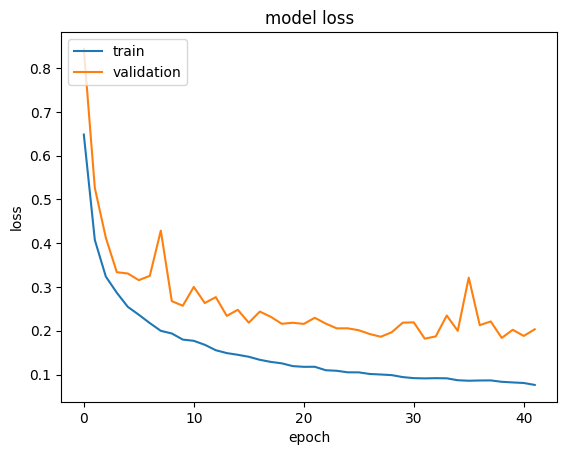

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Now I am going to use the model on test data.

In [14]:
print("Evaluate on test data")
results = resnet_1d.evaluate(X_test, y_test, batch_size=128) # One batch evaluation of the test data using the model
print("test loss, test acc:", results)

print("Generate predictions")
y_pred = resnet_1d.predict(X_test) # gives the predicted parameters of the data
print("predictions shape:", y_pred.shape) #gives the shape of the predicted parameter data set

Evaluate on test data
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1813 - mae: 0.2379
test loss, test acc: [0.18966670334339142, 0.2446490228176117]
Generate predictions
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
predictions shape: (2700, 5)


In [15]:
print(f"y_test shape: {y_test.shape}")
print(f"y_pred shape: {y_pred.shape}")


y_test shape: (2700, 5)
y_pred shape: (2700, 5)


In [16]:
comparison_df = pd.DataFrame({'True Values': y_test.flatten(), 'Predicted Values': y_pred.flatten()})

print(comparison_df.head()) #makes small comparison table of the y_true and y_predicted

   True Values  Predicted Values
0     1.417015          1.301190
1    -0.465997         -0.136429
2    -0.638596         -0.011001
3     0.011944         -0.211930
4     0.859192          0.979721


Above are the true values vs the predicted values made by the model. These are currently in z-score so are difficult to comprehend.

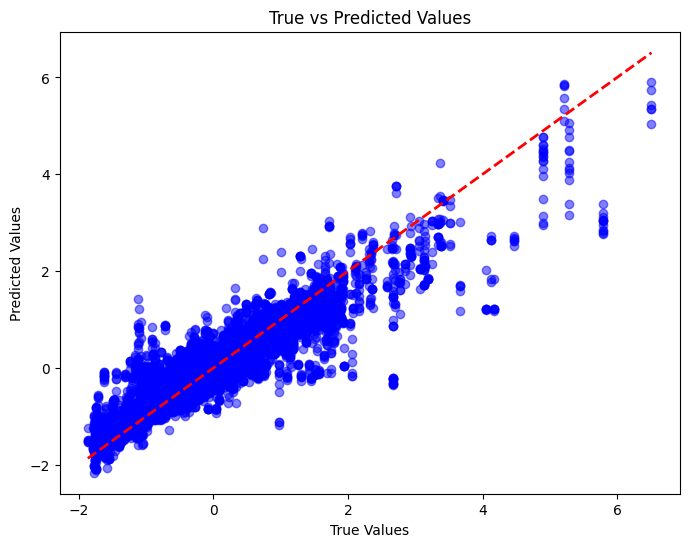

In [17]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Scatter plot of true vs predicted values
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)

# Use np.min and np.max to get the min and max values of y_test
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'r--', lw=2)  # Line y = x for reference

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')

plt.show()


To me this shows that the predictions are fairly accurate, however some erroneous predictions have been made. The best predictions are on the red line.

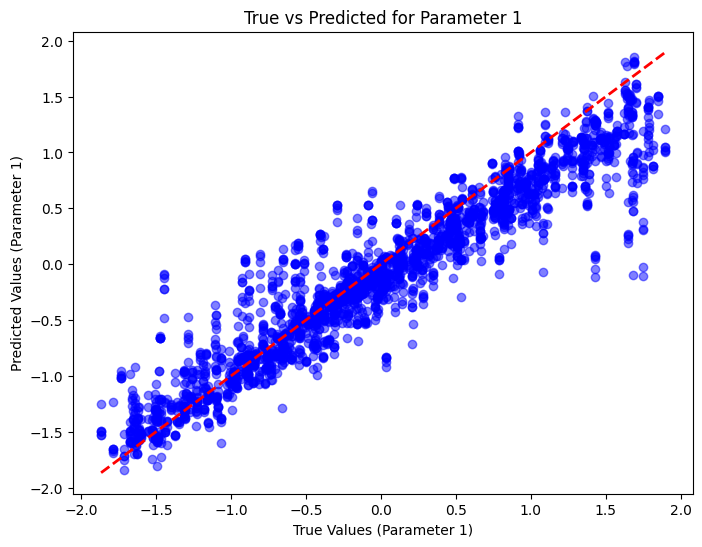

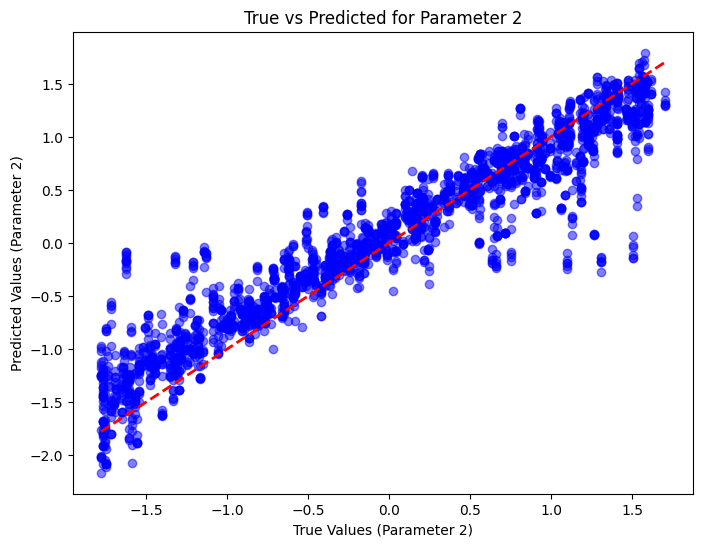

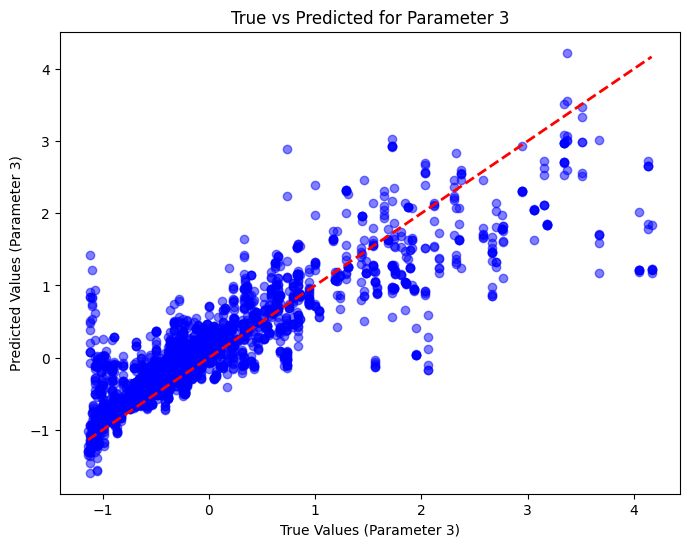

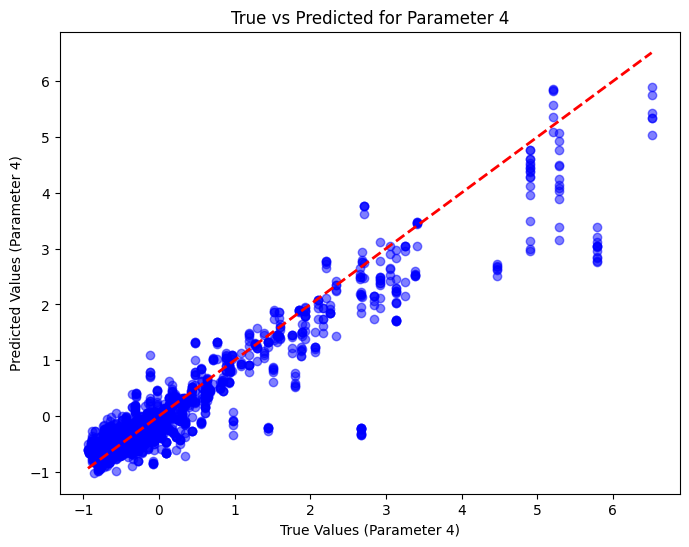

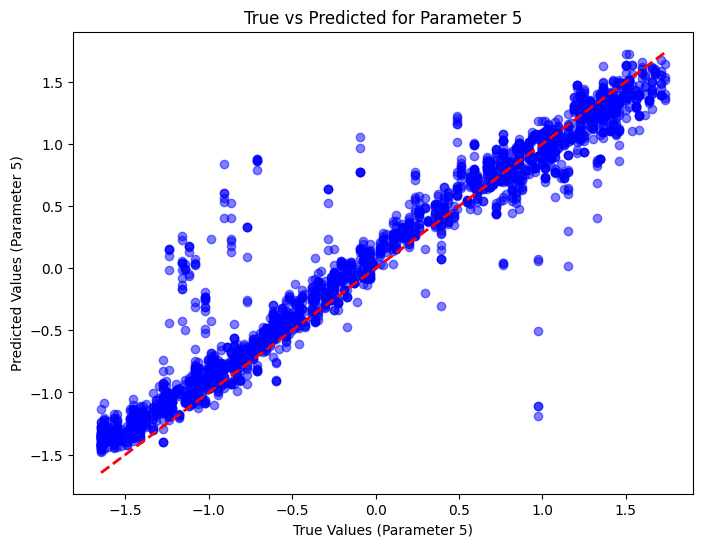

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test and y_pred have shape (3, 5)

# Loop through each parameter (i.e., each column in the arrays)
for i in range(y_test.shape[1]):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test[:, i], y_pred[:, i], color='blue', alpha=0.5)
    plt.plot([np.min(y_test[:, i]), np.max(y_test[:, i])],
             [np.min(y_test[:, i]), np.max(y_test[:, i])], 'r--', lw=2)  # Line y = x for reference
    plt.xlabel(f'True Values (Parameter {i+1})')
    plt.ylabel(f'Predicted Values (Parameter {i+1})')
    plt.title(f'True vs Predicted for Parameter {i+1}')
    plt.show()


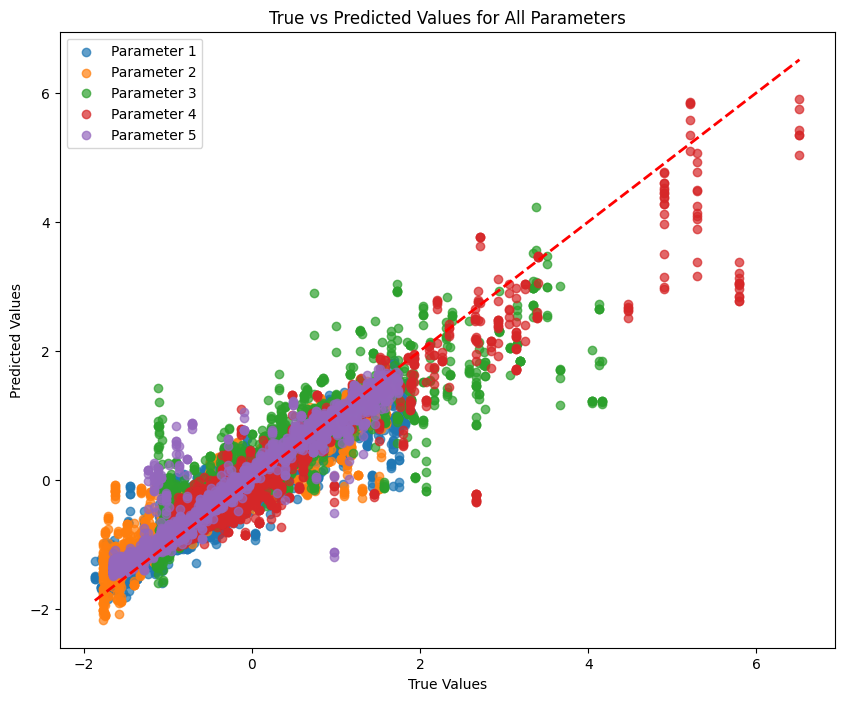

In [21]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Loop through each parameter (i.e., each column in the arrays)
for i in range(y_test.shape[1]):
    # Scatter plot for each parameter with different colors
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.7, label=f'Parameter {i+1}')

# Red dashed line for reference (y = x line)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'r--', lw=2)  # Line y = x for reference

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values for All Parameters')
plt.legend()
plt.show()


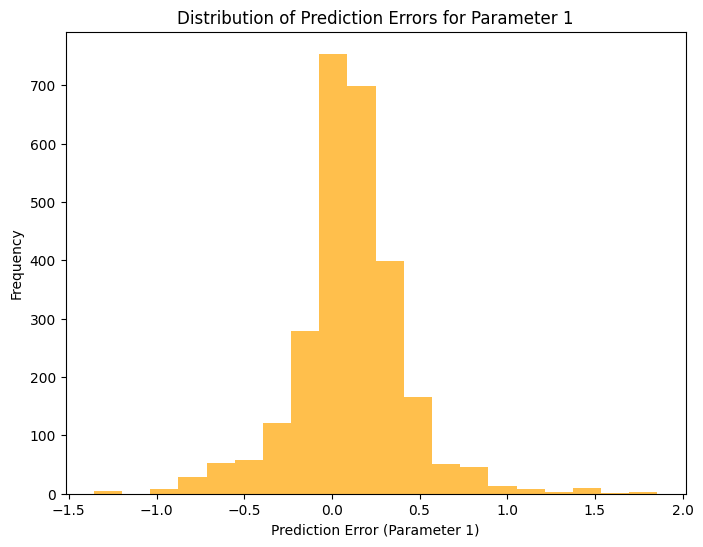

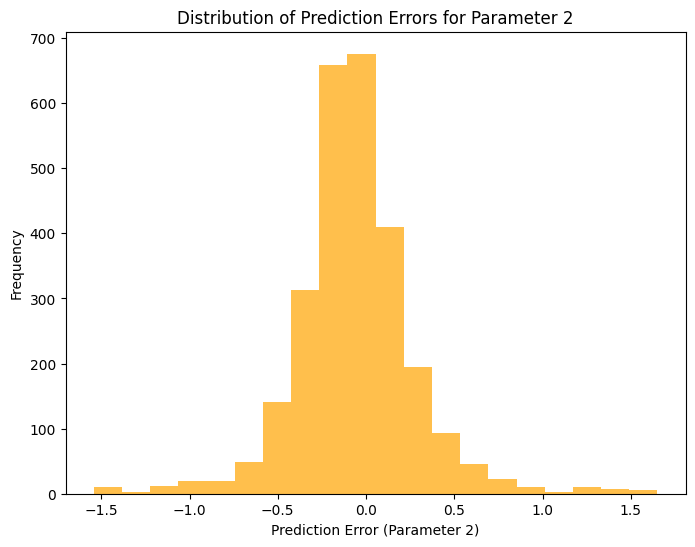

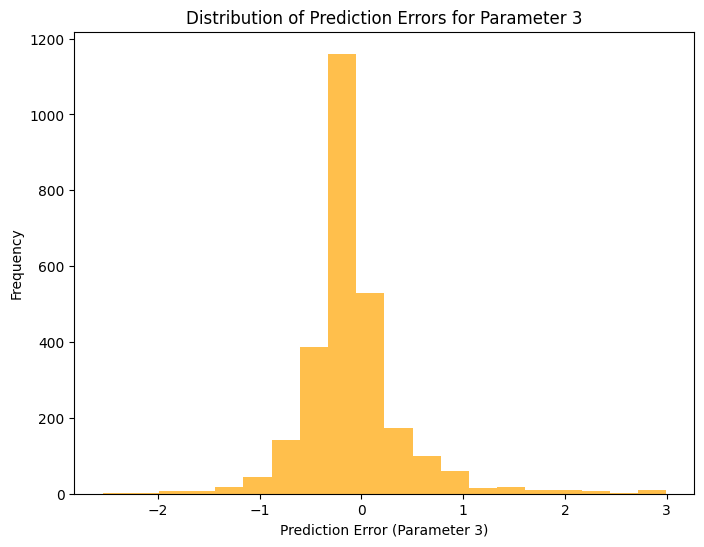

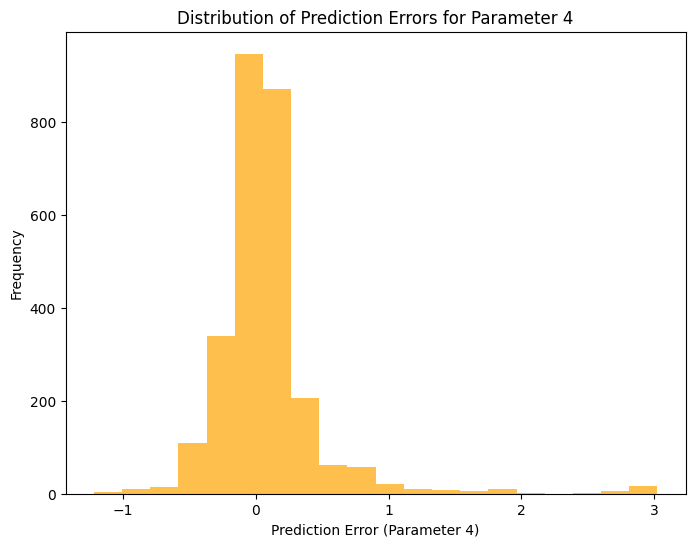

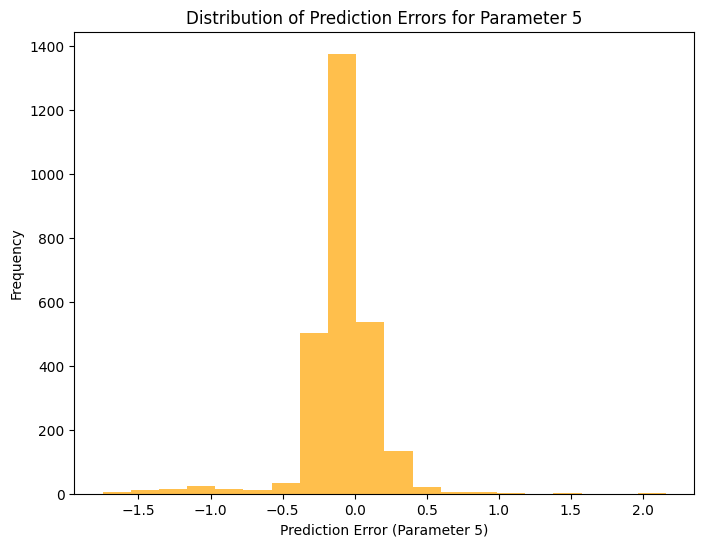

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test and y_pred have shape (3, 5)

# Loop through each parameter (i.e., each column in the arrays)
for i in range(y_test.shape[1]):
    # Calculate errors for each parameter
    errors = y_test[:, i] - y_pred[:, i]

    # Plot histogram of errors for each parameter
    plt.figure(figsize=(8, 6))
    plt.hist(errors, bins=20, color='orange', alpha=0.7)
    plt.xlabel(f'Prediction Error (Parameter {i+1})')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Prediction Errors for Parameter {i+1}')
    plt.show()


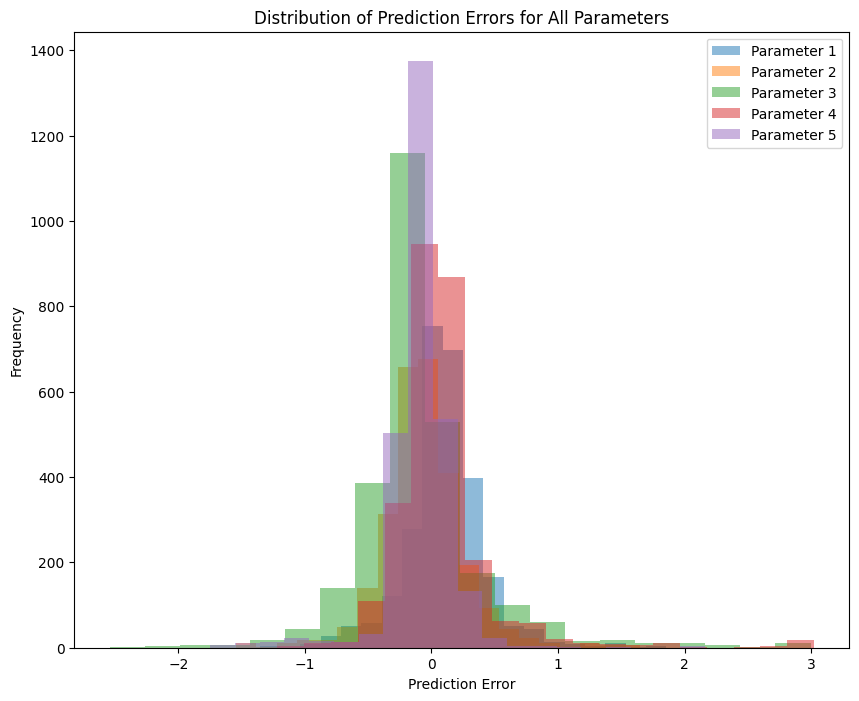

In [23]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Loop through each parameter (i.e., each column in the arrays)
for i in range(y_test.shape[1]):
    # Calculate errors for each parameter
    errors = y_test[:, i] - y_pred[:, i]

    # Plot histogram for the errors of each parameter
    plt.hist(errors, bins=20, alpha=0.5, label=f'Parameter {i+1}')

plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors for All Parameters')
plt.legend()
plt.show()


Above shows the correlation between true and predicted values for each parameters.

The other graph represents the distribution of error parameter values.

Next I want to show the time series itself, and convert the parameters back to their original values.